
--- Numerical Descriptive Statistics ---
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

--- Categorical Value Counts ---
sex       2
smoker    2
region    4
dtype: int64

sex counts:
sex
male      676
female    662
Name: count, dtype: int64

smoker counts:
smoker
no     1064
yes     274
Name: count, dtype: int64

region counts:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


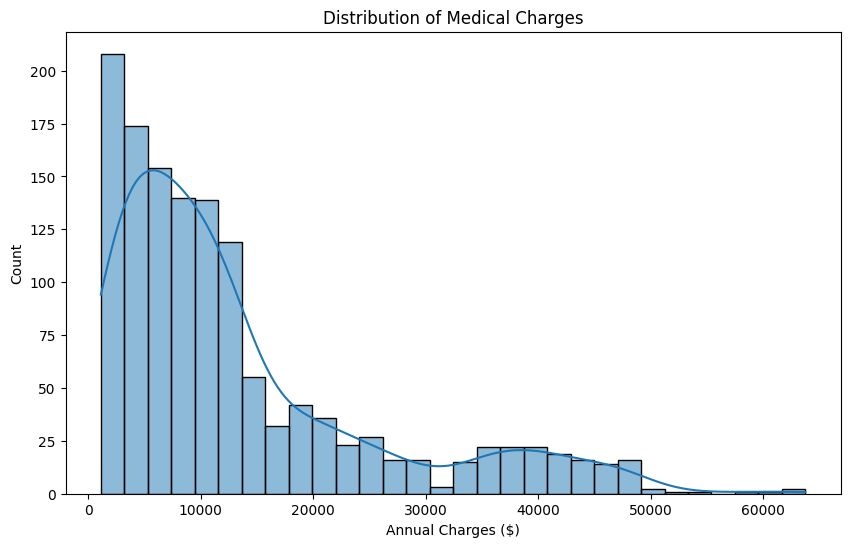


Skewness of Charges: 1.52


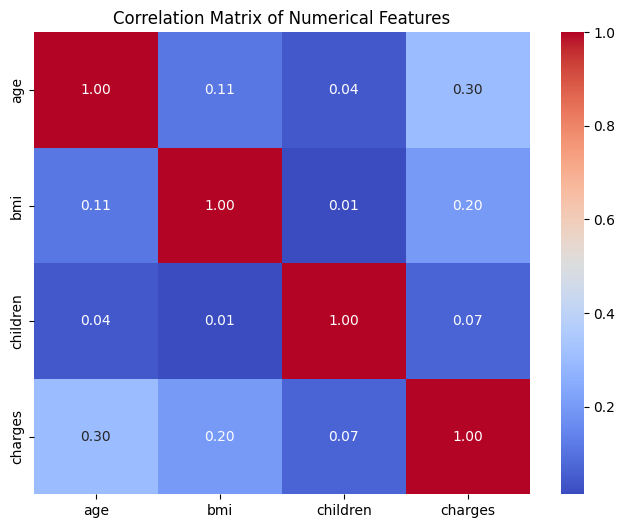

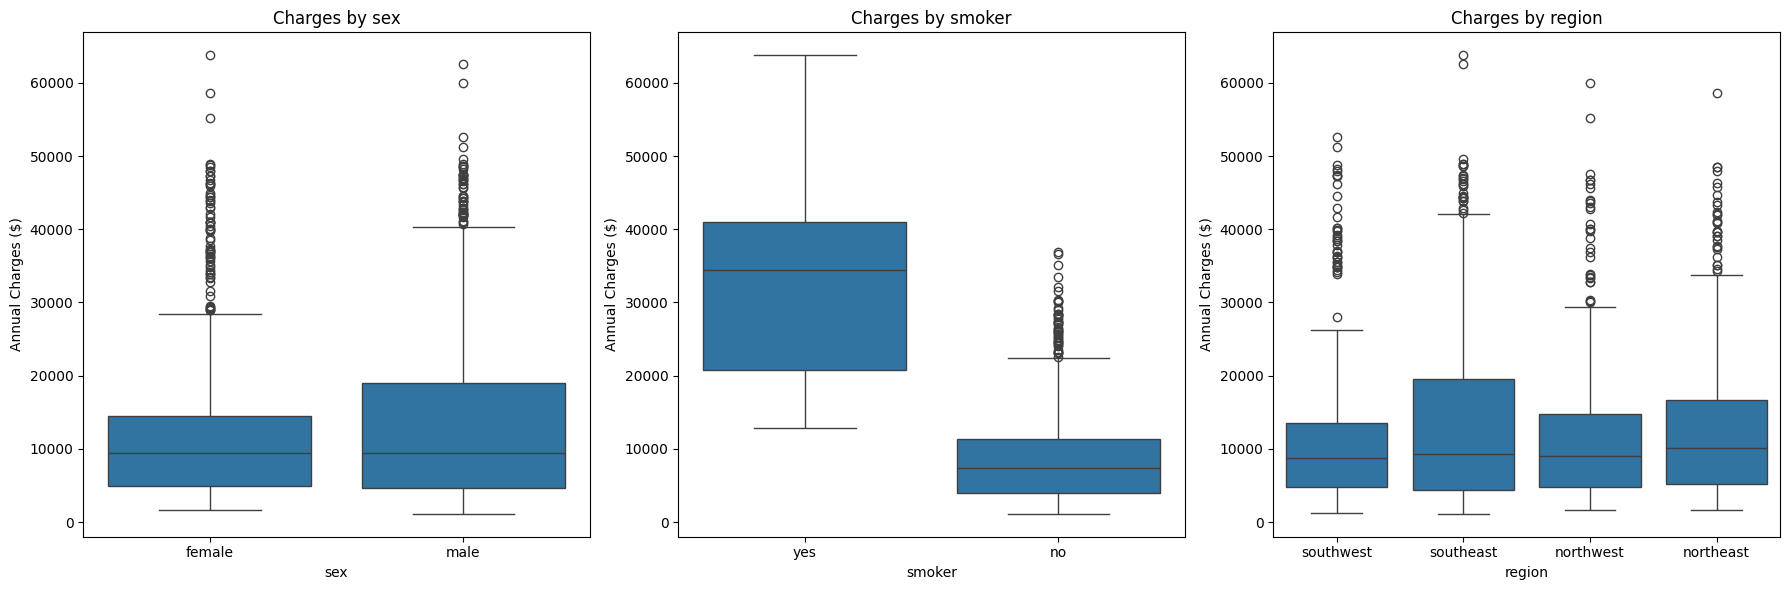

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Re-Load the data (crucial step!)
file_path = '../data/01_raw/insurance.csv' 
df = pd.read_csv(file_path)

# --- Phase 2.3: Descriptive Statistics ---

# Check basic statistics for numerical features
print("\n--- Numerical Descriptive Statistics ---")
print(df.describe())

# Check counts for categorical features
print("\n--- Categorical Value Counts ---")
print(df.select_dtypes(include='object').nunique()) # Number of unique values
for column in df.select_dtypes(include='object').columns:
    print(f"\n{column} counts:")
    print(df[column].value_counts())

# --- Phase 2.4: Target Variable Analysis (charges) ---
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Medical Charges')
plt.xlabel('Annual Charges ($)')
plt.show()

# Calculate the skewness
skewness = df['charges'].skew()x
print(f"\nSkewness of Charges: {skewness:.2f}")

# --- Phase 2.5: Numerical Feature Relationships ---
numerical_df = df.select_dtypes(include=np.number)
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# --- Phase 2.6: Categorical Feature Relationships ---
categorical_cols = ['sex', 'smoker', 'region']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(categorical_cols):
    sns.boxplot(x=col, y='charges', data=df, ax=axes[i])
    axes[i].set_title(f'Charges by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Annual Charges ($)')

plt.tight_layout()
plt.show()

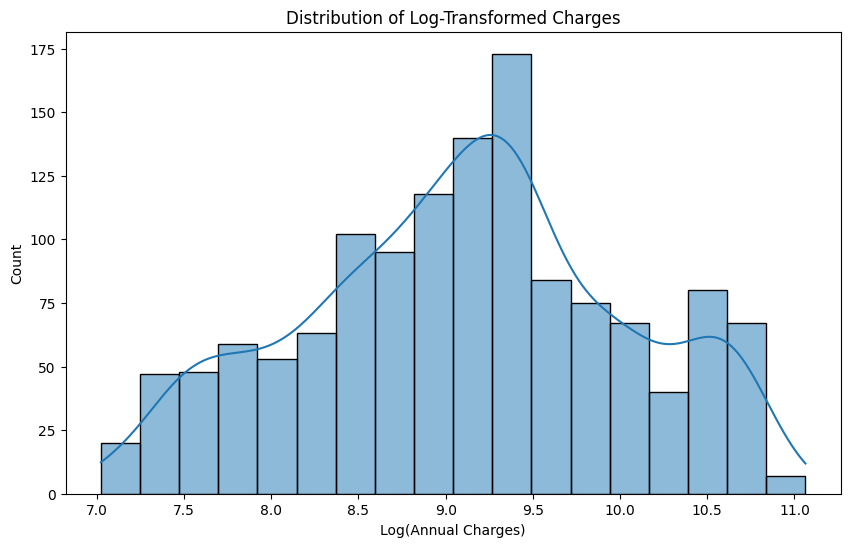

Skewness of Log Charges: -0.09


In [4]:
# 1. Log Transform the Target Variable (y)
df['log_charges'] = np.log(df['charges'])

# Check the new distribution (optional, but good practice to verify)
plt.figure(figsize=(10, 6))
sns.histplot(df['log_charges'], kde=True)
plt.title('Distribution of Log-Transformed Charges')
plt.xlabel('Log(Annual Charges)')
plt.show()

# You should see the skewness has significantly reduced (closer to 0).
print(f"Skewness of Log Charges: {df['log_charges'].skew():.2f}")

In [5]:
# 2. Create 'Is_Obese' Feature
# A common threshold for obesity is BMI > 30
df['Is_Obese'] = (df['bmi'] > 30).astype(int)

# 3. Create a Feature Interaction
# Let's explore if the effect of smoking is amplified for older or obese individuals.
# We will create a feature that multiplies the BMI with the Age.
df['bmi_age_interaction'] = df['bmi'] * df['age']

print("\n--- New Features Head ---")
print(df[['bmi', 'Is_Obese', 'bmi_age_interaction']].head())


--- New Features Head ---
      bmi  Is_Obese  bmi_age_interaction
0  27.900         0              530.100
1  33.770         1              607.860
2  33.000         1              924.000
3  22.705         0              749.265
4  28.880         0              924.160


In [6]:
# 4. One-Hot Encode Categorical Features
categorical_cols = ['sex', 'smoker', 'region']

# Use pd.get_dummies() to convert categorical columns to dummy variables (0 or 1)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

# We use drop_first=True to avoid the 'dummy variable trap' (multicollinearity).
# For example, we will only have 'sex_male'. If 'sex_male' is 0, we know it's female.

print("\n--- Encoded DataFrame Head (Showing new columns) ---")
print(df_encoded[['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast', 'region_southwest']].head())


--- Encoded DataFrame Head (Showing new columns) ---
   sex_male  smoker_yes  region_northwest  region_southeast  region_southwest
0         0           1                 0                 0                 1
1         1           0                 0                 1                 0
2         1           0                 0                 1                 0
3         1           0                 1                 0                 0
4         1           0                 1                 0                 0


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression # Still needed for the next step

# Assuming df_encoded is still in memory from Part 3.3
# If not, ensure you run the pd.get_dummies() block again to define df_encoded!

# 1. Define Features (X) and Target (y)
# We only drop the two target columns ('charges' is the original, 'log_charges' is the new target).
X = df_encoded.drop(columns=['charges', 'log_charges'])
y = df_encoded['log_charges']

# Confirming the final shape of the data
print(f"Features (X) Shape: {X.shape}")
print(f"Target (y) Shape: {y.shape}")

# 2. Split the data (80% Train, 20% Test)
# random_state ensures reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Set Size: {len(X_train)} samples")
print(f"Test Set Size: {len(X_test)} samples")

Features (X) Shape: (1338, 10)
Target (y) Shape: (1338,)

Training Set Size: 1070 samples
Test Set Size: 268 samples


In [9]:
# The LinearRegression library was imported in the previous block
from sklearn.linear_model import LinearRegression

# 1. Instantiate the model
model_baseline = LinearRegression()

# 2. Train the model using the training data
model_baseline.fit(X_train, y_train)

print("Baseline Linear Regression Model trained successfully.")

Baseline Linear Regression Model trained successfully.


In [10]:
from sklearn.metrics import r2_score, mean_squared_error

# 1. Generate predictions on the Test set
y_pred_log = model_baseline.predict(X_test)

# 2. Calculate R-squared (on the log-transformed data)
r2_log = r2_score(y_test, y_pred_log)

# 3. Inverse Transform for True RMSE Calculation
# Actual Charges in Dollars: Inverse transform y_test
y_test_original = np.exp(y_test)
# Predicted Charges in Dollars: Inverse transform y_pred_log
y_pred_original = np.exp(y_pred_log)

# 4. Calculate RMSE in Dollars (our primary metric)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# 5. Display the results
print("\n--- Baseline Model Performance (Linear Regression) ---")
print(f"R-squared on Log-Transformed Data: {r2_log:.4f}")
print(f"RMSE in Original Charge ($) Units: ${rmse_original:,.2f}")


--- Baseline Model Performance (Linear Regression) ---
R-squared on Log-Transformed Data: 0.8041
RMSE in Original Charge ($) Units: $7,790.82


In [11]:
from sklearn.ensemble import RandomForestRegressor

# 1. Instantiate the model
# We use a standard number of estimators (trees) and a fixed random state.
model_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model using the training data
model_rf.fit(X_train, y_train)

print("Random Forest Regressor Model trained successfully.")


Random Forest Regressor Model trained successfully.


In [12]:
# 1. Generate predictions on the Test set
y_pred_rf_log = model_rf.predict(X_test)

# 2. Calculate R-squared (on the log-transformed data)
r2_rf_log = r2_score(y_test, y_pred_rf_log)

# 3. Inverse Transform for True RMSE Calculation
# Predicted Charges in Dollars: Inverse transform
y_pred_rf_original = np.exp(y_pred_rf_log)

# 4. Calculate RMSE in Dollars (our primary metric)
rmse_rf_original = np.sqrt(mean_squared_error(y_test_original, y_pred_rf_original))

# 5. Display the results
print("\n--- Random Forest Model Performance ---")
print(f"R-squared on Log-Transformed Data: {r2_rf_log:.4f}")
print(f"RMSE in Original Charge ($) Units: ${rmse_rf_original:,.2f}")


--- Random Forest Model Performance ---
R-squared on Log-Transformed Data: 0.8465
RMSE in Original Charge ($) Units: $4,252.11


In [13]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    # Test a larger range of tree counts
    'n_estimators': [100, 200, 300],
    # Test different maximum depths for the trees
    'max_depth': [5, 10, 15],
    # Test different minimum samples required to split a node
    'min_samples_split': [2, 5, 10]
}

# 1. Instantiate the Grid Search object
# We use the negative mean squared error (neg_mean_squared_error) as the scoring metric.
# GridSearch will maximize this negative score, which is equivalent to minimizing MSE/RMSE.
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5, # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

print("Starting Grid Search...")
# 2. Execute the Grid Search on the training data
grid_search.fit(X_train, y_train)

# 3. Get the best parameters and the best model
best_params = grid_search.best_params_
best_score = grid_search.best_score_ # This is the best negative MSE
final_model = grid_search.best_estimator_

print("\n--- Grid Search Results ---")
print(f"Best Parameters Found: {best_params}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score:.4f}")

Starting Grid Search...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

--- Grid Search Results ---
Best Parameters Found: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300}
Best Cross-Validation Score (Negative MSE): -0.1502


In [14]:
# Evaluate the best model found by GridSearchCV
y_pred_final_log = final_model.predict(X_test)

# Calculate R-squared
r2_final_log = r2_score(y_test, y_pred_final_log)

# Inverse Transform and calculate final RMSE
y_pred_final_original = np.exp(y_pred_final_log)
rmse_final_original = np.sqrt(mean_squared_error(y_test_original, y_pred_final_original))

# Display the final, optimized results
print("\n--- FINAL OPTIMIZED MODEL PERFORMANCE ---")
print(f"R-squared on Log-Transformed Data: {r2_final_log:.4f}")
print(f"Final RMSE in Original Charge ($) Units: ${rmse_final_original:,.2f}")


--- FINAL OPTIMIZED MODEL PERFORMANCE ---
R-squared on Log-Transformed Data: 0.8610
Final RMSE in Original Charge ($) Units: $4,284.74



--- Top 5 Feature Importances ---
               Feature  Importance
6           smoker_yes    0.506751
0                  age    0.395438
2             children    0.034068
1                  bmi    0.026972
4  bmi_age_interaction    0.016770


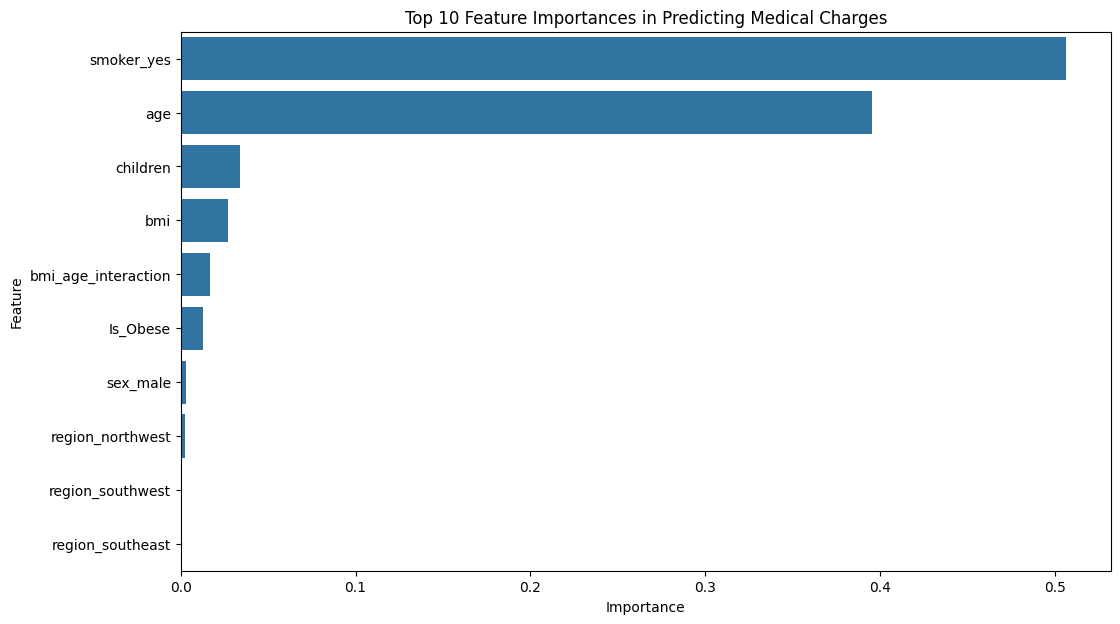

In [15]:
# Assuming final_model is the best_estimator_ from GridSearchCV
importances = final_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Top 5 Feature Importances ---")
print(feature_importance_df.head())

# Visualization for professional reporting
plt.figure(figsize=(12, 7))
# 
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances in Predicting Medical Charges')
plt.show()

In [16]:
import joblib

# Define the path to save the model
model_path = '../models/optimized_random_forest_regressor.pkl'

# Save the trained model object to the 'models' directory
# Assuming 'final_model' is the best_estimator_ from your GridSearchCV
joblib.dump(final_model, model_path)

print(f"Optimized model saved successfully to: {model_path}")

Optimized model saved successfully to: ../models/optimized_random_forest_regressor.pkl


In [17]:
import joblib

# Define the path to save the model.
# Make sure your notebook is running from a location 
# where this path resolves correctly to the 'models' folder.
model_path = '../models/optimized_random_forest_regressor.pkl' # Assuming notebook is in 'notebooks/'

# If your notebook is in the 'notebooks' folder, this path is correct.
# If you are running the notebook from the root, the path should be './models/...'
# Let's stick with the path that works when the notebook is in 'notebooks/':
joblib.dump(final_model, model_path)

print(f"Optimized model re-saved successfully to: {model_path}")

Optimized model re-saved successfully to: ../models/optimized_random_forest_regressor.pkl
